# Modelling Realistic Projectile Motion with Drag and Coriolis Forces

In [56]:
%matplotlib widget
# Makes the plot interactive
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [57]:
def acceleration(v, positions ,B, g, Omega, lambda_): # Function to compute total acceleration 
    # Gravitational force acting in the z direction 
    g_vec = np.array([0, 0, -g])
    
    # Drag force
    v_magnitude = np.linalg.norm(v)
    drag = -B * v_magnitude**2 * v / v_magnitude if v_magnitude != 0 else np.zeros(3) # Return an array of 3 zeros
    
    # Coriolis force
    omega_vec = Omega * np.array([np.cos(lambda_), 0, np.sin(lambda_)]) # Latitude dependent angular velocity vector
    coriolis = -2 * np.cross(v, omega_vec)
    
    # Total acceleration
    return g_vec + drag + coriolis

In [58]:
def rk2_step(position, velocity, dt, B, g, Omega, lambda_): # Runge-Kutta 2nd order method
    # Calculate the initial acceleration
    a1 = acceleration(velocity, position, B, g, Omega, lambda_)
    
    # Midpoint estimates
    v_mid = velocity + 0.5 * a1 * dt
    pos_mid = position + 0.5 * velocity * dt
    
    # Calculating the acceleration at the midpoint
    a2 = acceleration(v_mid, pos_mid, B, g, Omega, lambda_)
    
    # Updating the velocity and position
    new_velocity = velocity + a2 * dt
    new_position = position + velocity * dt
    
    return new_position, new_velocity

In [59]:
def rk4_step(position, velocity, dt, B, g, Omega, lambda_): # Runge-Kutta 4th order method
    # Calculate k1
    a1 = acceleration(velocity, position, B, g, Omega, lambda_)
    v1 = velocity
    p1 = position
    
    # Calculate k2
    a2 = acceleration(v1 + 0.5 * a1 * dt, p1 + 0.5 * v1 * dt, B, g, Omega, lambda_)
    v2 = v1 + 0.5 * a1 * dt
    p2 = p1 + 0.5 * v1 * dt
    
    # Calculate k3
    a3 = acceleration(v2 + 0.5 * a2 * dt, p2 + 0.5 * v2 * dt, B, g, Omega, lambda_)
    v3 = v2 + 0.5 * a2 * dt
    p3 = p2 + 0.5 * v2 * dt
    
    # Calculate k4
    a4 = acceleration(v3 + a3 * dt, p3 + v3 * dt, B, g, Omega, lambda_)
    v4 = v3 + a3 * dt
    p4 = p3 + v3 * dt
    
    # Update position and velocity
    new_position = position + (dt / 6.0) * (v1 + 2*v2 + 2*v3 + v4)
    new_velocity = velocity + (dt / 6.0) * (a1 + 2*a2 + 2*a3 + a4)
    
    return new_position, new_velocity


In [60]:
def simulate_projectile(method, initial_position, initial_velocity, B, g, Omega, lambda_, t_max, dt): # Function which employs either of the RK2 or RK4 methods
    position = np.array(initial_position)
    velocity = np.array(initial_velocity)
    t = 0
    positions = [position.copy()]
    
    while t < t_max:
        if method == "rk2":
            position, velocity = rk2_step(position, velocity, dt, B, g, Omega, lambda_) # If method is chosen as rk2, then use it to compute positions and velocities
        elif method == "rk4":
            position, velocity = rk4_step(position, velocity, dt, B, g, Omega, lambda_) # If method is chosen as rk4, then use it to compute positions and velocities
        
        positions.append(position.copy())
        t += dt
    
    return np.array(positions)

In [61]:
def plot_trajectory(positions): # Function to plot trajectory in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    positions = np.array(positions)


    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2])
    ax.set_xlabel('x / m')
    ax.set_ylabel('y / m')
    ax.set_zlabel('z / m')
    ax.set_title("Realistic Projectile Motion with Drag and Coriolis Forces")
    plt.show()

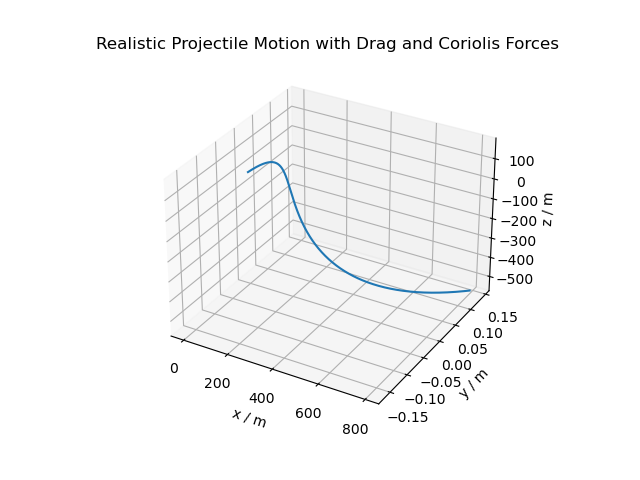

In [62]:
# Parameters which can be changed
g = 9.81  # Gravitational acceleration 
B = 0.001 # Coefficient of drag
Omega = 7.292e-5  # angular velocity of Earth in rad/s
lambda_ = np.radians(0)  # Converting latitude in degrees to radians

# Defining some initial conditions
v0 = 100  # Initial launch speed 
angle = np.radians(45)  # Converting the launch angle to radians
initial_position = [0, 0, 0]  # Assuming starting at the origin
initial_velocity = [v0 * np.cos(angle), 0, v0 * np.sin(angle)]  # Initial velocity 

t_max = 20  # Total simulation time in seconds
dt = 0.01  # Time step in seconds

# Run the simulation using RK2 or RK4
positions = simulate_projectile("rk2", initial_position, initial_velocity, B, g, Omega, lambda_, t_max, dt)

# Plot the results
plot_trajectory(positions)

In [63]:
def get_max_altitude_and_range(positions): # Function which gets maximum altitude and maximum range
    
    max_altitude = np.max(positions[:, 2])# Maximum altitude is the maximum z value
    
    # The range is the x-y distance when the projectile hits the ground at z = 0
    for i in range(1, len(positions)):
        if positions[i, 2] <= 0:  # Check when it crosses the ground
            # Linear interpolation to estimate range when z = 0
            x1, y1, z1 = positions[i - 1]
            x2, y2, z2 = positions[i]
            t = -z1 / (z2 - z1)  # Interpolation factor for z = 0 crossing
            range_x = x1 + t * (x2 - x1)
            range_y = y1 + t * (y2 - y1)
            range_ = np.sqrt(range_x**2 + range_y**2)
            return max_altitude, range_
    
    
    return max_altitude, np.sqrt(positions[-1, 0]**2 + positions[-1, 1]**2)# If the projectile never returns to the ground, return the last position

In [64]:
def simulate_for_latitudes(initial_position, initial_velocity, B, g, Omega, latitudes, t_max, dt): # Function which simulates over a range of given latitudes to return the maximum range and altitude 
    max_altitudes = []
    ranges = []
    for lat in latitudes:
        lambda_ = np.radians(lat)
        positions = simulate_projectile("rk4", initial_position, initial_velocity, B, g, Omega, lambda_, t_max, dt)
        max_altitude, range_ = get_max_altitude_and_range(positions)
        max_altitudes.append(max_altitude)
        ranges.append(range_)
    return max_altitudes, ranges

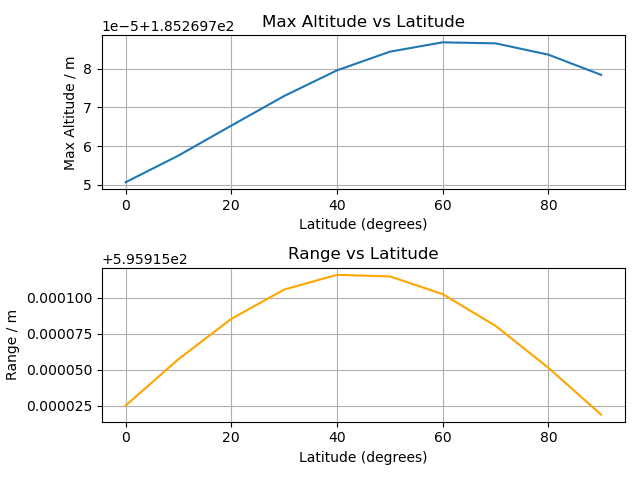

In [65]:
latitudes = np.linspace(0, 90, 10)  # Range of latitudes to test from equator to higher latitudes.

# Initial conditions (same as before)
initial_position = [0, 0, 0]
initial_velocity = [v0 * np.cos(angle), 0, v0 * np.sin(angle)]
t_max = 20
dt = 0.01

# Run simulations for different latitudes
max_altitudes, ranges = simulate_for_latitudes(initial_position, initial_velocity, B, g, Omega, latitudes, t_max, dt)

# Plot the results for maximum range and maximum altitude 
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(latitudes, max_altitudes, label='Max Altitude')
plt.xlabel('Latitude (degrees)')
plt.ylabel('Max Altitude / m')
plt.title('Max Altitude vs Latitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(latitudes, ranges, label='Range', color='orange')
plt.xlabel('Latitude (degrees)')
plt.ylabel('Range / m')
plt.title('Range vs Latitude')
plt.grid(True)

plt.tight_layout()
plt.show()

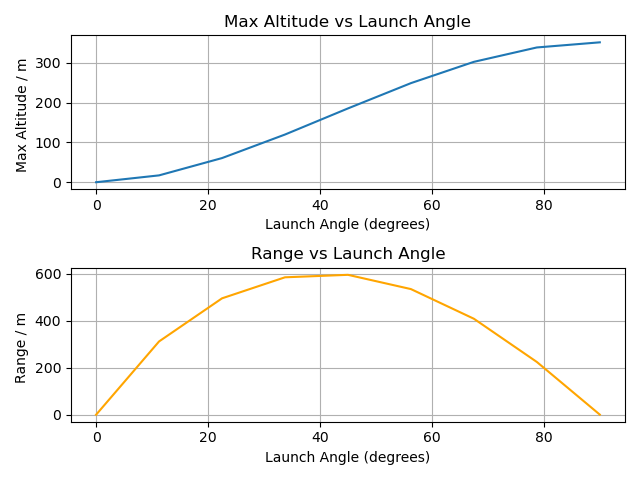

In [66]:
def simulate_for_angles(initial_position, initial_speeds, B, g, Omega, lambda_, angles, t_max, dt): # Function which simulates over a range of given launch angles to return the maximum range and altitude 
    max_altitudes = []
    ranges = []
    for angle in angles:
        initial_velocity = [v0 * np.cos(angle), 0, v0 * np.sin(angle)]
        positions = simulate_projectile("rk4", initial_position, initial_velocity, B, g, Omega, lambda_, t_max, dt)
        max_altitude, range_ = get_max_altitude_and_range(positions)
        max_altitudes.append(max_altitude)
        ranges.append(range_)
    return max_altitudes, ranges

# Range of angles to test from 0 to 90 degrees
angles = np.radians(np.linspace(0, 90, 9))  
initial_speeds = np.linspace(0, 90, 10) 

# Run simulations for different angles
max_altitudes, ranges = simulate_for_angles(initial_position, initial_speeds, B, g, Omega, lambda_, angles, t_max, dt)

# Plot results for maximum altitude and maximum range
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(np.degrees(angles), max_altitudes, label='Max Altitude')
plt.xlabel('Launch Angle (degrees)')
plt.ylabel('Max Altitude / m ')
plt.title('Max Altitude vs Launch Angle')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.degrees(angles), ranges, label='Range', color='orange')
plt.xlabel('Launch Angle (degrees)')
plt.ylabel('Range / m ')
plt.title('Range vs Launch Angle')
plt.grid(True)

plt.tight_layout()
plt.show()